In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import glob
import pandas as pd
from keplerdata import Dataset
plt.rcParams['figure.figsize'] = [12,10]
from tqdm import tqdm

In [80]:
datadir = '/home/davies/Projects/ClusterUp/Data/MNLNGC6791-20180307-231444/output/KASOC_Corrected_timeseries/'
sfiles = glob.glob(datadir + '*.dat')
df = pd.read_csv('/home/davies/Dropbox/K2_seismo_pipes/NGC6791/Data/NGC6791.csv')
df['EPIC'] = df.KIC
df_out = pd.read_csv('/home/davies/Projects/K2_seismo_pipes/KeplerGold/output_NGC6791.csv')
df_out['KIC'] = df_out.ID
df = df.merge(df_out, on='KIC', how='inner')

df = df[df.KIC != 2436097]
df = df[df.KIC != 2436593]
df = df[df.KIC != 2436954]
df = df[df.KIC != 2436759]
df = df[df.KIC != 2437496]

n = 3
df = df[:n**2]
smoo = 100
dss = [Dataset(row.EPIC, glob.glob(datadir + 'kplr*' + str(row.EPIC) + '*.dat')[0]) for idx, row in df.iterrows()]
for ds in tqdm(dss):
    ds.power_spectrum(dfN=(0.01, 28800*2))
    ds.rebin_quick(smoo)
power = [ds.smoo_power for ds in dss]
freq = dss[0].smoo_freq

100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


In [81]:
data = np.zeros([len(dss[0].smoo_power), len(dss)])
for idx, p in enumerate(power):
    data[:,idx] = p
low = int(4.0 / (freq[1] - freq[0]))
freq = freq[low:]
data = data[low:, :]

Text(0,0.5,'Rebinned power')

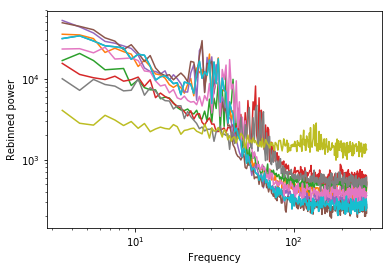

In [82]:
fig, ax = plt.subplots()
for idx, d in enumerate(data[0,:]):
    plt.plot(freq, data[:, idx])
ax.plot(freq, data[:,0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('Rebinned power')

In [83]:
df.loc[df.KIC == 2436593, 'Numax'] = 28.0
df.loc[df.KIC == 2438140, 'Numax'] = 72.0
numaxs = df.Numax.values
whites = np.median(data[-3:,:], axis=0)
kics = df.KIC.values

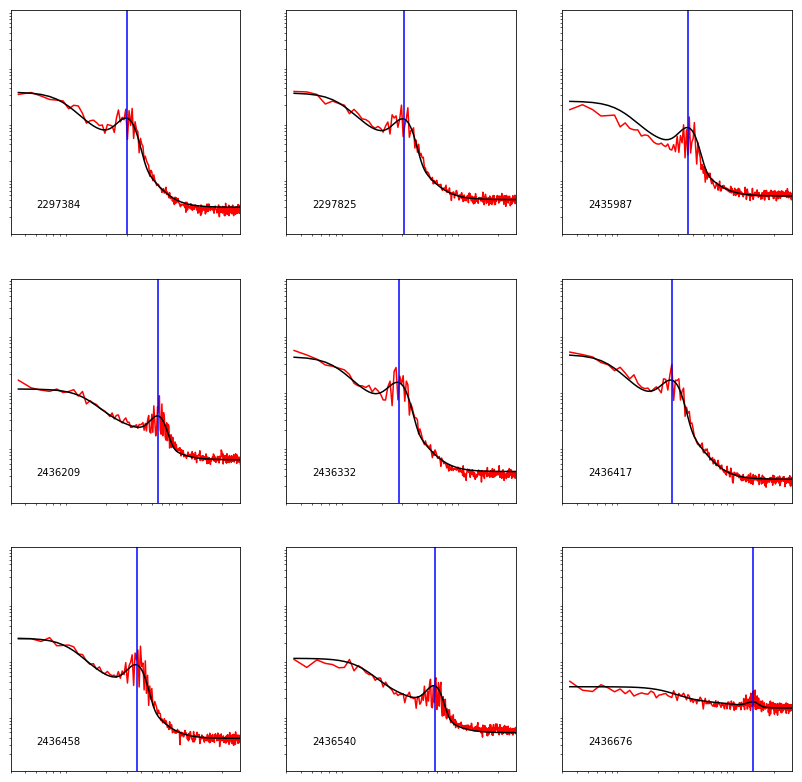

In [84]:
def harvey(f, a, b, c=4.0):
    return 0.9*a**2/b/(1 + (f/b)**c)
def gaussian(f, numax, width, height):
    return height * np.exp(-0.5 * (f - numax)**2 / width**2)
def apod(f, nyq):
    x = f / 2.0 / nyq
    
    return np.sinc(x)**2
def model(f, ak, ae, bk, be, ck, ce, dk, de, numax, wk, we, hk, he, white):
    a = 10**(ak + numax*ae)
    b = 10**(bk + numax*be)
    c = 10**(ck + numax*ce)
    d = 10**(dk + numax*de)
    width = 10**(wk + numax*we)
    height = 10**(hk + numax*he)
    model = (apod(f, 288.8) * (harvey(f, a, b) + harvey(f, c, d) + gaussian(f, 10**numax, width, height))) + 10**white
    return model
ak, ae = 3.67, -0.63
bk, be = -0.1, 0.72
ck, ce = 3.35, -0.49
dk, de = 0.29, 0.81
wk, we = -0.28, 0.68
hk, he = 7.06, -2.11
fig, ax = plt.subplots(n,n, figsize=[14, 14])
for i in range(0, n*n):
    x = i // n
    y = i % n
    fit0 = model(freq, 
                 ak, ae, bk, be, 
                 ck, ce, dk, de, np.log10(numaxs[i]), 
                 wk, we, hk, he, 
                 np.log10(whites[i]))
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3 ,288])
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])
    ax[x, y].text(5, 3e2, str(kics[i]))

Text(0,0.5,'Log White Noise')

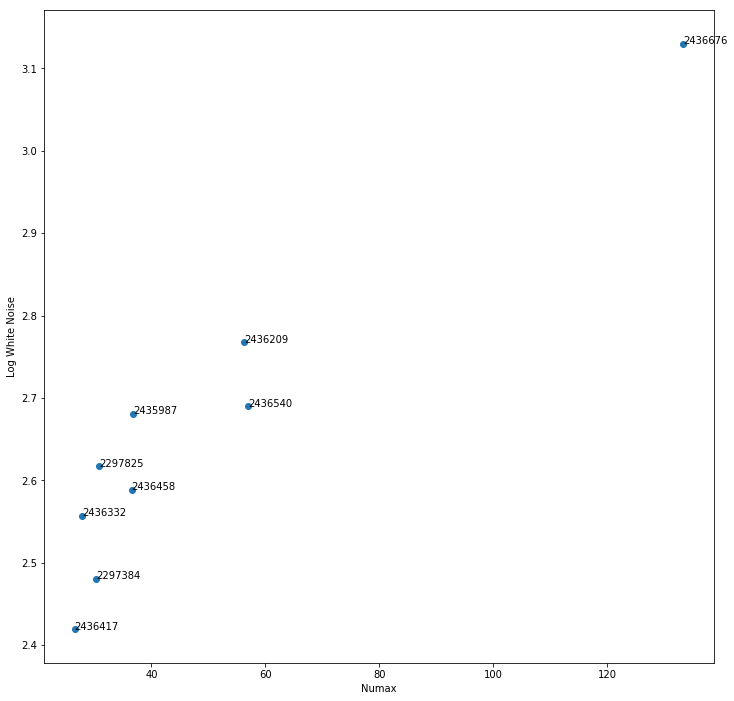

In [85]:
fig, ax = plt.subplots(figsize=[12,12])
ax.scatter(numaxs, np.log10(whites))
for i in range(len(kics)):
    ax.text(numaxs[i], np.log10(whites[i]), str(kics[i]))
ax.set_xlabel('Numax')
ax.set_ylabel('Log White Noise')

The gamma function in stan is parameterised in a way I'm not used to (wiki says the stan way is common in Bayesian stats).  Let's investigate.

${\rm Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x}$.

This parameterisation gives a mean value $\frac{\alpha }{\beta}$ and a variance of $\frac{\alpha}{\beta^{2}}$.  $\alpha$ is called the shape and $\beta$ is called the rate.

$\alpha$ is the same parameter as the shape $k$ in my familiar notation.  The rate $\beta$ is then the recipricol of the scale, i.e., $\theta = \frac{1}{\beta}$.

When fitting a power spectrum the data are the model multiplied by the noise distribution.  If we calculate the data divided by the model we are left with the noise distirbution.  

In [86]:
code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    int M;
    int dof;
    vector[N] f;
    real p[N, M];
    vector[M] numax_est;
    vector[M] white_est;

}
parameters {
    real ae;
    real be;
    real ce;
    real de;
    real<lower = 3.0> ak;
    real bk;
    real<lower = 3.0> ck;
    real dk;
    real wk;
    real we;
    real hk;
    real he;
    vector[M] numax_std;
    real<lower = 0> numaxspread;
    vector[M] white_std;
    real<lower = 0> whitespread;
    real<lower = 0> aspread;
    real<lower = 0> bspread;
    real<lower = 0> cspread;
    real<lower = 0> dspread;
    real<lower = 0> wspread;
    real<lower = 0> hspread;
    vector[M] a_std;
    vector[M] b_std;
    vector[M] c_std;
    vector[M] d_std;
    vector[M] w_std;
    vector[M] h_std;
    real<lower=0> nu;
}
transformed parameters {
    vector[M] a;
    vector[M] b;
    vector[M] c;
    vector[M] d;
    vector[M] w;
    vector[M] h;
    vector[M] numax;
    vector[M] white;
    numax = numax_std * numaxspread + numax_est;
    white = white_std * whitespread + white_est;
    for (j in 1:M){
        a[j] = 10^((ak + numax[j] * ae) + a_std[j] * aspread);
        b[j] = 10^((bk + (numax[j]) * be) + b_std[j] * bspread);
        c[j] = 10^((ck + (numax[j]) * ce) + c_std[j] * cspread);
        d[j] = 10^((dk + (numax[j]) * de) + d_std[j] * dspread);
        w[j] = 10^((wk + (numax[j]) * we) + w_std[j] * wspread);
        h[j] = 10^((hk + (numax[j]) * he) + h_std[j] * hspread);
    }
}
model {
    real beta[N, M];
    for (j in 1:M){
        for (i in 1:N){
            beta[i, j] = dof / (apod(f[i], 288.8)
                        * (harvey(f[i], a[j], b[j], 4.0)
                        + harvey(f[i], c[j], d[j], 4.0)
                        + gaussian(f[i], 10^numax[j], w[j], h[j]))
                        + 10^white[j]);
        }
        p[1:N, j] ~ gamma(dof, beta[1:N, j]);
    }
    ak ~ normal(3.65, 0.5); // log 10
    ae ~ normal(-0.62, 0.5);
    bk ~ normal(-0.15, 0.5); //log10
    be ~ normal(0.74, 0.5);
    ck ~ normal(3.39, 0.5); // log10
    ce ~ normal(-0.51, 0.5);
    dk ~ normal(0.27, 0.5); //log10
    de ~ normal(0.83, 0.5);
    wk ~ normal(-0., 0.5); // log10
    we ~ normal(1.0, 0.5);
    hk ~ normal(6.93, 0.5); // log10
    he ~ normal(-2.18, 0.5);
    numax_std ~ normal(0, 1);
    numaxspread ~ normal(0, 0.1);
    white_std ~ normal(0, 1);
    whitespread ~ normal(0, 0.1);
    a_std ~ student_t(nu, 0, 1);
    b_std ~ student_t(nu, 0, 1);
    c_std ~ student_t(nu, 0, 1);
    d_std ~ student_t(nu, 0, 1);
    w_std ~ student_t(nu, 0, 1);
    h_std ~ student_t(nu, 0, 1);
    aspread ~ normal(0, 0.1);
    bspread ~ normal(0, 0.1);
    cspread ~ normal(0, 0.1);
    dspread ~ normal(0, 0.1);
    wspread ~ normal(0, 0.1);
    hspread ~ normal(0, 0.1);
    nu ~ normal(5, 5);
}
'''
sm = pystan.StanModel(model_code=code, model_name='backfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_9a61846526bb62b5cf00c3fca91a1f6d NOW.


In [87]:
dat = {'N': len(freq),
       'M': len(numaxs),
       'dof': smoo,
      'f': freq,
      'p': data,
      'numax_est': np.log10(numaxs),
      'white_est': np.log10(whites)}
ak, ae = 3.62, -0.61
bk, be = -0.27, 0.8
ck, ce = 3.57, -0.61
dk, de = 0.18, 0.87
wk, we = -0.33, 0.69
hk, he = 6.99, -2.05
start = {'ak': ak, 'ae': ae, 'bk': bk, 'be': be, 
          'ck': ck, 'ce': ce, 'dk': dk, 'de': de, 
          'wk': wk, 'we': we, 'hk': hk, 'he': he,
          'a_std': np.zeros(len(numaxs)), 'aspread': 0.02,
          'b_std': np.zeros(len(numaxs)), 'bspread': 0.02,
          'c_std': np.zeros(len(numaxs)), 'cspread': 0.02,
          'd_std': np.zeros(len(numaxs)), 'dspread': 0.02,
          'w_std': np.zeros(len(numaxs)), 'wspread': 0.02,
          'h_std': np.zeros(len(numaxs)), 'hspread': 0.02,
          'numax_std': np.zeros(len(numaxs)), 'numaxspread': 0.02,
          'white_std': np.zeros(len(numaxs)), 'whitespread': 0.02,
          'nu': 2.0}
# Note dof is not actually dof but is in fact the number of bins over which we have smoothed.
nchains = 4
fit = sm.sampling(data=dat, iter=1000, chains=nchains, init=[start for n in range(nchains)])

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [97]:
print(fit)

Inference for Stan model: backfit_9a61846526bb62b5cf00c3fca91a1f6d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ae            -0.65  2.2e-3   0.06  -0.78  -0.69  -0.65  -0.62  -0.52    842    1.0
be             0.82  2.0e-3   0.07   0.67   0.78   0.82   0.86   0.95   1113    1.0
ce            -0.68  2.6e-3   0.08  -0.84  -0.73  -0.68  -0.63  -0.52    937    1.0
de             0.93  1.7e-3   0.06   0.82   0.89   0.93   0.97   1.04   1168    1.0
ak              3.7  3.6e-3    0.1   3.49   3.64    3.7   3.76    3.9    811    1.0
bk            -0.26  3.3e-3   0.11  -0.47  -0.33  -0.26  -0.19  -0.02   1116    1.0
ck             3.67  4.2e-3   0.13   3.41   3.59   3.67   3.75   3.92    921    1.0
dk              0.1  2.7e-3   0.09  -0.08   0.04    0.1   0.16   0.28   1144    1.0
wk             -0.2  4.8e-3   0.15  -0.49   -0.3  -0.19   -0

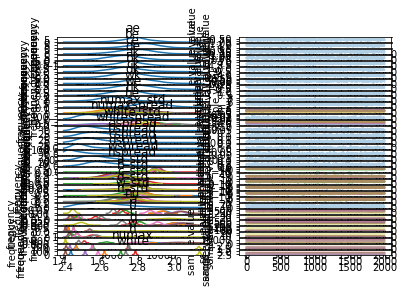

In [98]:
fit.plot()
plt.show()

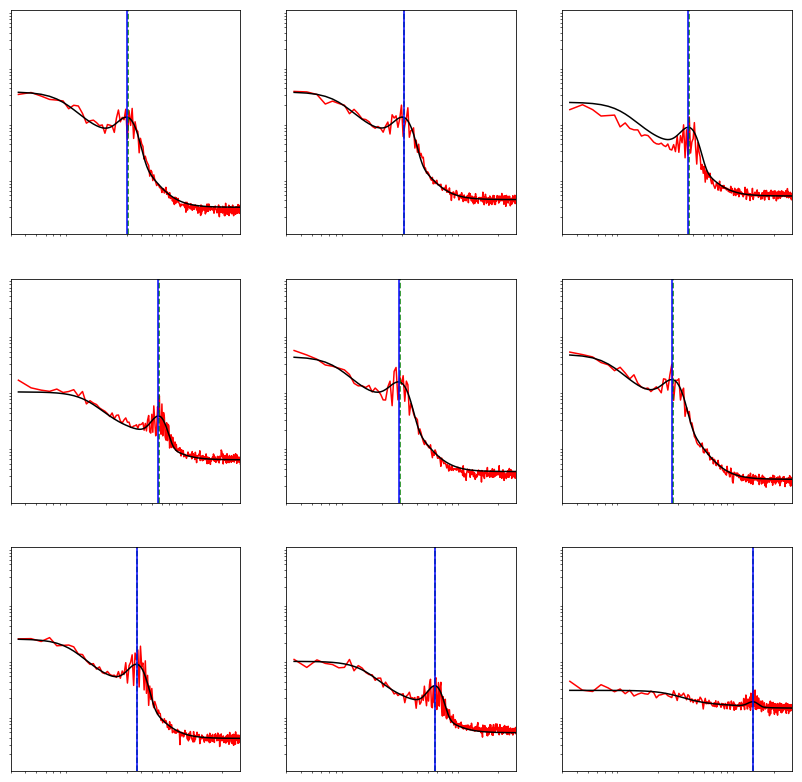

In [101]:

def model(f, ak, ae, bk, be, ck, ce, dk, de, numax, wk, we, hk, he, white):
    a = 10**(ak + numax*ae)
    b = 10**(bk + numax*be)
    c = 10**(ck + numax*ce)
    d = 10**(dk + numax*de)
    width = 10**(wk + numax*we)
    height = 10**(hk + numax*he)
    model = (apod(f, 288.8) * (harvey(f, a, b) + harvey(f, c, d) + gaussian(f, 10**numax, width, height))) + 10**white
    return model
fig, ax = plt.subplots(n,n, figsize=[14, 14])
ak = fit['ak'].mean()
ae = fit['ae'].mean()
bk = fit['bk'].mean()
be = fit['be'].mean()
ck = fit['ck'].mean()
ce = fit['ce'].mean()
dk = fit['dk'].mean()
de = fit['de'].mean()
wk = fit['wk'].mean()
we = fit['we'].mean()
hk = fit['hk'].mean()
he = fit['he'].mean()
numax = np.mean(fit['numax'], axis=0)
white = np.log10(whites)
for i in range(0, n*n):
    fit0 = model(freq, ak, ae, bk, be, ck, ce, dk, de, numax[i], wk, we, hk, he, white[i])
    x = i // n
    y = i % n
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3 ,288])
    ax[x, y].axvline(10**numax[i], c='g', linestyle='--')
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])

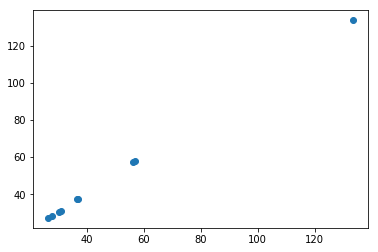

In [102]:
fig, ax = plt.subplots()
ax.scatter(numaxs, 10**fit['numax'].mean(axis=0))

In [103]:
print(((10**fit['numax']).std(axis=0)/(10**fit['numax']).mean(axis=0)).mean())

0.007355672394633375


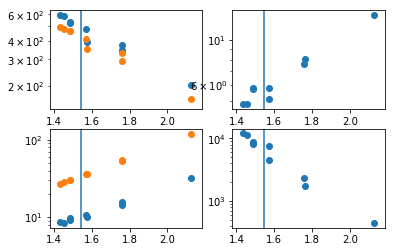

In [110]:
fig, ax = plt.subplots(2,2)
ax[0,0].scatter(fit['numax'].mean(axis=0), fit['a'].mean(axis=0))
ax[1,0].scatter(fit['numax'].mean(axis=0), fit['b'].mean(axis=0))
ax[0,0].scatter(fit['numax'].mean(axis=0), fit['c'].mean(axis=0))
ax[1,0].scatter(fit['numax'].mean(axis=0), fit['d'].mean(axis=0))
ax[0,0].set_yscale('log')
ax[1,0].set_yscale('log')
ax[0,1].scatter(fit['numax'].mean(axis=0), fit['w'].mean(axis=0))
ax[1,1].scatter(fit['numax'].mean(axis=0), fit['h'].mean(axis=0))
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,0].axvline(np.log10(35.0))
ax[0,1].axvline(np.log10(35.0))
ax[1,0].axvline(np.log10(35.0))
ax[1,1].axvline(np.log10(35.0))

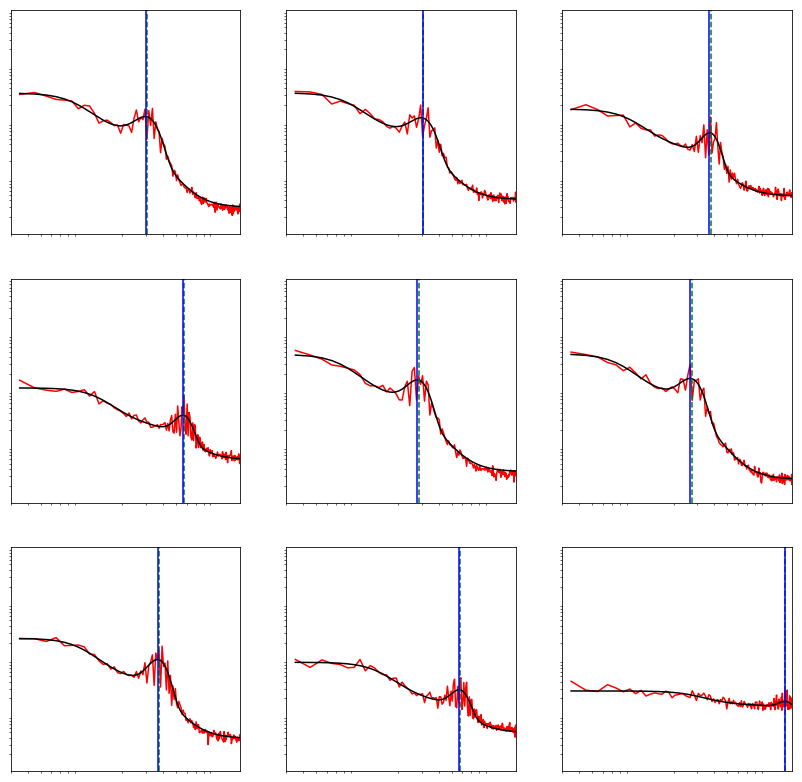

In [94]:
def model(f, a, b, c, d, numax, w, h, white):
    model = (apod(f, 288.8) * (harvey(f, a, b) + harvey(f, c, d) + gaussian(f, 10**numax, w, h))) + 10**white
    return model
fig, ax = plt.subplots(n,n, figsize=[14, 14])
numax = np.mean(fit['numax'], axis=0)
white = np.log10(whites)
for i in range(0, n*n):
    fit0 = model(freq, fit['a'][:,i].mean(), fit['b'][:,i].mean(),
                 fit['c'][:,i].mean(), fit['d'][:,i].mean(),
                 fit['numax'][:,i].mean(),
                 fit['w'][:,i].mean(), fit['h'][:,i].mean(),
                 white[i])
    x = i // n
    y = i % n
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1e2, 1e6])
    ax[x, y].set_xlim([3.0 ,150])
    ax[x, y].axvline(10**numax[i], c='g', linestyle='--')
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])

In [95]:
print(10**numax)

[ 30.6114427   30.7145378   37.54504982  57.250681    28.49111894
  27.22534566  37.16439201  57.92947679 133.72772687]


In [96]:
print(numaxs)

[ 30.25290983  30.82468873  36.81361513  56.29481995  27.80522212
  26.53125771  36.5510339   56.9385267  133.37752291]
